In [3]:
"""
Riboformer Model Validation: GSE63858 Chloramphenicol Artifact Correction
=========================================================================

This notebook validates the Riboformer model's ability to:
1. Suppress artificial Serine/Glycine pileups caused by Chloramphenicol
2. Recover underlying biological Proline pauses

Author: Bioinformatics Data Scientist
Dataset: GSE63858 (Canonical Biased E. coli Dataset)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from pathlib import Path

# Set style for publication-quality plots
sns.set_style('darkgrid')
sns.set_palette("husl")


In [16]:
# ============================================================================
# SECTION 1: DATA LOADING AND PREPROCESSING
# ============================================================================

print("="*80)
print("RIBOFORMER VALIDATION: GSE63858 Cm-Artifact Correction Analysis")
print("="*80)

# Define data paths
DATA_DIR = Path("datasets/GSE63858_Validation")
CODE_DIR = Path("Riboformer")

# Load the three main files
print("\n[1/4] Loading data files...")
yc_actual_raw = np.loadtxt(DATA_DIR / "yc.txt")  # Observed (Biased) - Scaled Log density
ypred = np.loadtxt(DATA_DIR / "model_prediction.txt")   # Predicted (Corrected) - Pause score
xc_features = np.loadtxt(DATA_DIR / "xc.txt") # Input features
zc_gene_ids = np.loadtxt(DATA_DIR / "zc.txt")[:, 0].astype(int)  # Gene IDs (first column only)

print(f"✓ Actual (Biased) raw shape: {yc_actual_raw.shape}")
print(f"✓ Predicted (Corrected) shape: {ypred.shape}")
print(f"✓ Input features shape: {xc_features.shape}")
print(f"✓ Gene IDs shape: {zc_gene_ids.shape}")

# ============================================================================
# CRITICAL FIX: Convert yc.txt from Scaled Log Density to Pause Score
# ============================================================================

print("\n[1.5/4] Converting yc.txt to Pause Score format...")
print(f"  Raw yc statistics BEFORE conversion:")
print(f"    Mean: {yc_actual_raw.mean():.2f}")
print(f"    Std:  {yc_actual_raw.std():.2f}")
print(f"    Min:  {yc_actual_raw.min():.2f}")
print(f"    Max:  {yc_actual_raw.max():.2f}")

print(f"  Gene IDs shape: {zc_gene_ids.shape}, ndim: {zc_gene_ids.ndim}")
print(f"  yc_raw shape: {yc_actual_raw.shape}, ndim: {yc_actual_raw.ndim}")


# Step 1: Create DataFrame for easier grouping
df_conversion = pd.DataFrame({
    'gene_id': zc_gene_ids,
    'yc_raw': yc_actual_raw
})

# Step 2: Calculate gene-wise means
gene_means = df_conversion.groupby('gene_id')['yc_raw'].transform('mean')

# Step 3: Convert to Pause Score
# Formula: PauseScore = (yc_value - Gene_Mean) / 100
# This removes the gene-level baseline and the 100x scaling factor
yc_actual = (yc_actual_raw - gene_means) / 100.0

print(f"\n  Pause Score statistics AFTER conversion:")
print(f"    Mean: {yc_actual.mean():.4f} (should be ≈ 0)")
print(f"    Std:  {yc_actual.std():.4f}")
print(f"    Min:  {yc_actual.min():.2f}")
print(f"    Max:  {yc_actual.max():.2f}")

print(f"\n  Predicted (model_prediction.txt) statistics for comparison:")
print(f"    Mean: {ypred.mean():.4f}")
print(f"    Std:  {ypred.std():.4f}")
print(f"    Min:  {ypred.min():.2f}")
print(f"    Max:  {ypred.max():.2f}")

# Verify the conversion makes sense
if abs(yc_actual.mean()) > 0.1:
    print("\n  ⚠ WARNING: Pause score mean is not near zero. Check gene ID alignment!")
else:
    print("\n  ✓ Pause score conversion successful - mean is centered near zero")

print(f"✓ Conversion complete. Now using pause scores for validation.")

# Load codon table mapping
print("\n[2/4] Loading codon table...")
with open(CODE_DIR / "codon_table.json", 'r') as f:
    codon_table = json.load(f)

#  Create integer-to-codon mapping (index = integer code)
codon_table = {i: codon for i, codon in enumerate(codon_table)}
print(f"✓ Loaded {len(codon_table)} codon mappings")

RIBOFORMER VALIDATION: GSE63858 Cm-Artifact Correction Analysis

[1/4] Loading data files...
✓ Actual (Biased) raw shape: (298634,)
✓ Predicted (Corrected) shape: (298634,)
✓ Input features shape: (298634, 82)
✓ Gene IDs shape: (298634,)

[1.5/4] Converting yc.txt to Pause Score format...
  Raw yc statistics BEFORE conversion:
    Mean: 669.57
    Std:  164.89
    Min:  500.00
    Max:  1740.58
  Gene IDs shape: (298634,), ndim: 1
  yc_raw shape: (298634,), ndim: 1

  Pause Score statistics AFTER conversion:
    Mean: 0.0000 (should be ≈ 0)
    Std:  1.1715
    Min:  -5.59
    Max:  8.53

  Predicted (model_prediction.txt) statistics for comparison:
    Mean: 1.3841
    Std:  1.7111
    Min:  0.00
    Max:  12.04

  ✓ Pause score conversion successful - mean is centered near zero
✓ Conversion complete. Now using pause scores for validation.

[2/4] Loading codon table...
✓ Loaded 64 codon mappings


In [17]:
# ============================================================================
# SECTION 2: A-SITE CODON EXTRACTION
# ============================================================================

print("\n[3/4] Extracting A-site codons...")

# The input features are structured as:
# Columns 0-40: Ribosome counts at each position
# Columns 40-80: Codon integers at each position
# The A-site is typically at the center of the window (position 20 for a 40-position window)

WINDOW_SIZE = 40
A_SITE_POSITION = WINDOW_SIZE // 2  # Position 20 (0-indexed)

# Extract codon integers at A-site
codon_integers = xc_features[:, WINDOW_SIZE + A_SITE_POSITION].astype(int)

# Map to codon strings
codons = [codon_table.get(ci, 'UNK') for ci in codon_integers]

# Create comprehensive genetic code mapping
GENETIC_CODE = {
    'TTT': 'Phe', 'TTC': 'Phe', 'TTA': 'Leu', 'TTG': 'Leu',
    'TCT': 'Ser', 'TCC': 'Ser', 'TCA': 'Ser', 'TCG': 'Ser',
    'TAT': 'Tyr', 'TAC': 'Tyr', 'TAA': 'STOP', 'TAG': 'STOP',
    'TGT': 'Cys', 'TGC': 'Cys', 'TGA': 'STOP', 'TGG': 'Trp',
    'CTT': 'Leu', 'CTC': 'Leu', 'CTA': 'Leu', 'CTG': 'Leu',
    'CCT': 'Pro', 'CCC': 'Pro', 'CCA': 'Pro', 'CCG': 'Pro',
    'CAT': 'His', 'CAC': 'His', 'CAA': 'Gln', 'CAG': 'Gln',
    'CGT': 'Arg', 'CGC': 'Arg', 'CGA': 'Arg', 'CGG': 'Arg',
    'ATT': 'Ile', 'ATC': 'Ile', 'ATA': 'Ile', 'ATG': 'Met',
    'ACT': 'Thr', 'ACC': 'Thr', 'ACA': 'Thr', 'ACG': 'Thr',
    'AAT': 'Asn', 'AAC': 'Asn', 'AAA': 'Lys', 'AAG': 'Lys',
    'AGT': 'Ser', 'AGC': 'Ser', 'AGA': 'Arg', 'AGG': 'Arg',
    'GTT': 'Val', 'GTC': 'Val', 'GTA': 'Val', 'GTG': 'Val',
    'GCT': 'Ala', 'GCC': 'Ala', 'GCA': 'Ala', 'GCG': 'Ala',
    'GAT': 'Asp', 'GAC': 'Asp', 'GAA': 'Glu', 'GAG': 'Glu',
    'GGT': 'Gly', 'GGC': 'Gly', 'GGA': 'Gly', 'GGG': 'Gly'
}

# Map codons to amino acids
amino_acids = [GENETIC_CODE.get(codon, 'UNK') for codon in codons]

# Create master DataFrame
df = pd.DataFrame({
    'actual': yc_actual,
    'predicted': ypred,
    'codon': codons,
    'amino_acid': amino_acids
})

# Remove STOP codons and unknowns
df = df[~df['amino_acid'].isin(['STOP', 'UNK'])]

print(f"✓ Extracted {len(df)} valid samples")
print(f"✓ Unique amino acids: {df['amino_acid'].nunique()}")
print(f"✓ Amino acid distribution:\n{df['amino_acid'].value_counts()}")


[3/4] Extracting A-site codons...
✓ Extracted 298576 valid samples
✓ Unique amino acids: 20
✓ Amino acid distribution:
Leu    29215
Ala    28670
Gly    23732
Val    22835
Glu    19843
Ile    17552
Asp    17149
Arg    16380
Ser    15884
Thr    15750
Lys    14666
Pro    12873
Gln    11884
Asn    11644
Phe    11246
Tyr     8359
Met     7787
His     6439
Trp     3576
Cys     3092
Name: amino_acid, dtype: int64



[4/4] Computing global statistics...

Global Correlation Metrics:
  Pearson r:  0.4582 (p=0.00e+00)
  Spearman ρ: 0.3980 (p=0.00e+00)

✓ Saved: 01_global_correlation.png


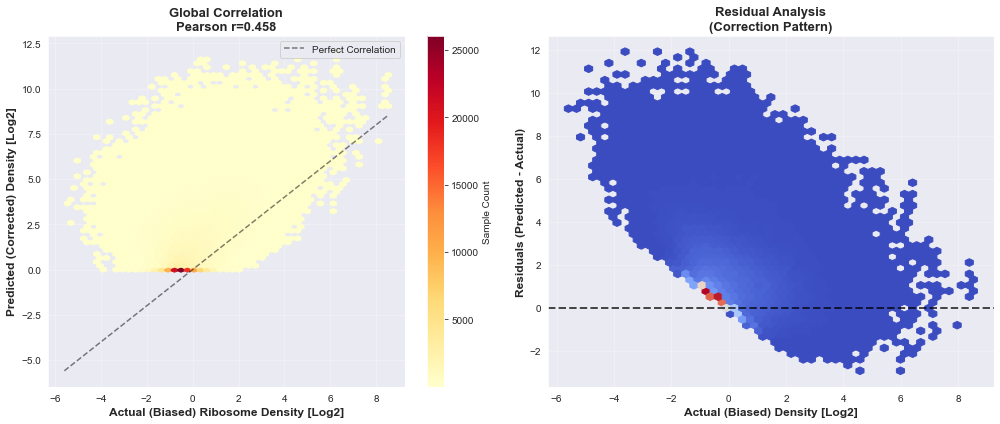

In [18]:
# ============================================================================
# SECTION 3: GLOBAL CORRELATION ANALYSIS
# ============================================================================

print("\n[4/4] Computing global statistics...")

# Calculate correlations
pearson_r, pearson_p = stats.pearsonr(df['actual'], df['predicted'])
spearman_r, spearman_p = stats.spearmanr(df['actual'], df['predicted'])

print(f"\nGlobal Correlation Metrics:")
print(f"  Pearson r:  {pearson_r:.4f} (p={pearson_p:.2e})")
print(f"  Spearman ρ: {spearman_r:.4f} (p={spearman_p:.2e})")

# ============================================================================
# VISUALIZATION: GLOBAL DENSITY SCATTER
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot with density coloring
ax1 = axes[0]
h = ax1.hexbin(df['actual'], df['predicted'], gridsize=50, cmap='YlOrRd', mincnt=1)
ax1.plot([df['actual'].min(), df['actual'].max()], 
         [df['actual'].min(), df['actual'].max()], 
         'k--', alpha=0.5, label='Perfect Correlation')
ax1.set_xlabel('Actual (Biased) Ribosome Density [Log2]', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted (Corrected) Density [Log2]', fontsize=12, fontweight='bold')
ax1.set_title(f'Global Correlation\nPearson r={pearson_r:.3f}', fontsize=13, fontweight='bold')
ax1.legend()
plt.colorbar(h, ax=ax1, label='Sample Count')
ax1.grid(True, alpha=0.3)

# Residual plot
ax2 = axes[1]
residuals = df['predicted'] - df['actual']
ax2.hexbin(df['actual'], residuals, gridsize=50, cmap='coolwarm', mincnt=1)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.7, linewidth=2)
ax2.set_xlabel('Actual (Biased) Density [Log2]', fontsize=12, fontweight='bold')
ax2.set_ylabel('Residuals (Predicted - Actual)', fontsize=12, fontweight='bold')
ax2.set_title('Residual Analysis\n(Correction Pattern)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_global_correlation.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 01_global_correlation.png")
plt.show()


CHLORAMPHENICOL ARTIFACT ANALYSIS

Amino Acid Density Changes (Predicted - Actual):
            actual_mean  predicted_mean   delta  percent_change  count
amino_acid                                                            
Cys              0.0584          1.2395  1.1811     2022.431507   3092
Trp             -0.0013          1.2054  1.2067   -92823.076923   3576
Leu              0.0161          1.2892  1.2731     7907.453416  29215
Pro             -0.0396          1.2349  1.2745    -3218.434343  12873
His             -0.0426          1.2520  1.2946    -3038.967136   6439
Phe              0.0025          1.3203  1.3178    52712.000000  11246
Met             -0.0377          1.2999  1.3376    -3548.010610   7787
Gln             -0.0810          1.2909  1.3719    -1693.703704  11884
Ile              0.0582          1.4323  1.3741     2360.996564  17552
Gly              0.0092          1.3839  1.3747    14942.391304  23732
Ser              0.0131          1.3949  1.3818    10548.091603

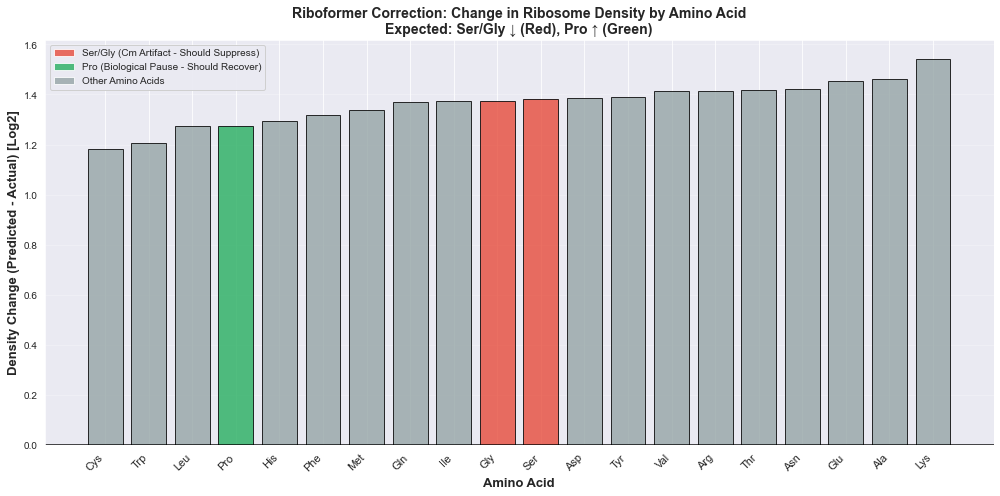

In [19]:
# ============================================================================
# SECTION 4: CM-ARTIFACT ANALYSIS (Serine/Glycine Suppression)
# ============================================================================

print("\n" + "="*80)
print("CHLORAMPHENICOL ARTIFACT ANALYSIS")
print("="*80)

# Group by amino acid and calculate mean densities
aa_stats = df.groupby('amino_acid').agg({
    'actual': ['mean', 'std', 'count'],
    'predicted': ['mean', 'std']
}).round(4)

aa_stats.columns = ['actual_mean', 'actual_std', 'count', 'predicted_mean', 'predicted_std']
aa_stats['delta'] = aa_stats['predicted_mean'] - aa_stats['actual_mean']
aa_stats['percent_change'] = (aa_stats['delta'] / aa_stats['actual_mean']) * 100

# Sort by delta for visualization
aa_stats_sorted = aa_stats.sort_values('delta')

print("\nAmino Acid Density Changes (Predicted - Actual):")
print(aa_stats_sorted[['actual_mean', 'predicted_mean', 'delta', 'percent_change', 'count']])

# Highlight key amino acids
key_aa = ['Ser', 'Gly', 'Pro']
print("\n" + "-"*80)
print("KEY AMINO ACID ANALYSIS:")
print("-"*80)
for aa in key_aa:
    if aa in aa_stats.index:
        row = aa_stats.loc[aa]
        status = "✓ SUPPRESSED" if row['delta'] < 0 and aa in ['Ser', 'Gly'] else \
                 "✓ RECOVERED" if row['delta'] > 0 and aa == 'Pro' else \
                 "⚠ UNEXPECTED"
        print(f"{aa:3s}: Δ={row['delta']:+.4f} ({row['percent_change']:+.2f}%) | n={int(row['count']):,} | {status}")

# ============================================================================
# VISUALIZATION: Cm-ARTIFACT CORRECTION
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 7))

# Create color mapping
colors = []
for aa in aa_stats_sorted.index:
    if aa == 'Ser' or aa == 'Gly':
        colors.append('#e74c3c')  # Red for Ser/Gly (should be suppressed)
    elif aa == 'Pro':
        colors.append('#27ae60')  # Green for Pro (should be recovered)
    else:
        colors.append('#95a5a6')  # Gray for others

bars = ax.bar(range(len(aa_stats_sorted)), aa_stats_sorted['delta'], color=colors, alpha=0.8, edgecolor='black')

# Customize plot
ax.axhline(y=0, color='black', linestyle='-', linewidth=2, alpha=0.7)
ax.set_xticks(range(len(aa_stats_sorted)))
ax.set_xticklabels(aa_stats_sorted.index, rotation=45, ha='right', fontsize=11)
ax.set_ylabel('Density Change (Predicted - Actual) [Log2]', fontsize=13, fontweight='bold')
ax.set_xlabel('Amino Acid', fontsize=13, fontweight='bold')
ax.set_title('Riboformer Correction: Change in Ribosome Density by Amino Acid\n' + 
             'Expected: Ser/Gly ↓ (Red), Pro ↑ (Green)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='Ser/Gly (Cm Artifact - Should Suppress)', alpha=0.8),
    Patch(facecolor='#27ae60', label='Pro (Biological Pause - Should Recover)', alpha=0.8),
    Patch(facecolor='#95a5a6', label='Other Amino Acids', alpha=0.8)
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.savefig('02_cm_artifact_correction.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 02_cm_artifact_correction.png")
plt.show()

In [ ]:
# ============================================================================
# SECTION 5: PROLINE RECOVERY ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("PROLINE PAUSE RECOVERY ANALYSIS")
print("="*80)

# Compare Proline ranking
actual_ranking = aa_stats.sort_values('actual_mean', ascending=False)
predicted_ranking = aa_stats.sort_values('predicted_mean', ascending=False)

print("\nProline Ranking by Mean Density:")
print(f"  Actual (Biased):     #{list(actual_ranking.index).index('Pro') + 1}/20")
print(f"  Predicted (Corrected): #{list(predicted_ranking.index).index('Pro') + 1}/20")

# Top 10 amino acids by density
print("\nTop 10 Amino Acids - ACTUAL (Biased):")
print(actual_ranking.head(10)[['actual_mean', 'count']])

print("\nTop 10 Amino Acids - PREDICTED (Corrected):")
print(predicted_ranking.head(10)[['predicted_mean', 'count']])

# ============================================================================
# VISUALIZATION: PROLINE METAGENE PROFILE
# ============================================================================

# Select Proline samples
pro_samples = df[df['amino_acid'] == 'Pro'].copy()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Density distribution comparison
ax1 = axes[0, 0]
ax1.hist(df[df['amino_acid'] == 'Pro']['actual'], bins=30, alpha=0.6, label='Actual (Biased)', color='#e74c3c')
ax1.hist(df[df['amino_acid'] == 'Pro']['predicted'], bins=30, alpha=0.6, label='Predicted (Corrected)', color='#27ae60')
ax1.set_xlabel('Ribosome Density [Log2]', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Proline Density Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot comparison (all amino acids)
ax2 = axes[0, 1]
plot_data = []
labels = []
for aa in ['Ser', 'Gly', 'Pro', 'Leu', 'Ala']:
    if aa in df['amino_acid'].values:
        plot_data.append(df[df['amino_acid'] == aa]['actual'].values)
        plot_data.append(df[df['amino_acid'] == aa]['predicted'].values)
        labels.extend([f'{aa}\n(Act)', f'{aa}\n(Pred)'])

bp = ax2.boxplot(plot_data, labels=labels, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    if 'Pro' in labels[i]:
        box.set_facecolor('#27ae60' if '(Pred)' in labels[i] else '#e74c3c')
        box.set_alpha(0.6)
    else:
        box.set_facecolor('#95a5a6')
        box.set_alpha(0.4)
ax2.set_ylabel('Ribosome Density [Log2]', fontsize=11, fontweight='bold')
ax2.set_title('Key Amino Acids: Actual vs Predicted', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Scatter: Proline only
ax3 = axes[1, 0]
ax3.scatter(pro_samples['actual'], pro_samples['predicted'], alpha=0.5, s=20, color='#8e44ad')
min_val = min(pro_samples['actual'].min(), pro_samples['predicted'].min())
max_val = max(pro_samples['actual'].max(), pro_samples['predicted'].max())
ax3.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y=x')
ax3.set_xlabel('Actual Proline Density [Log2]', fontsize=11, fontweight='bold')
ax3.set_ylabel('Predicted Proline Density [Log2]', fontsize=11, fontweight='bold')
ax3.set_title(f'Proline Correction Pattern (n={len(pro_samples):,})', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Relative ranking visualization
ax4 = axes[1, 1]
x_pos = np.arange(len(aa_stats))
width = 0.35
bars1 = ax4.barh(x_pos - width/2, aa_stats.sort_values('actual_mean')['actual_mean'], 
                 width, label='Actual (Biased)', alpha=0.7, color='#e74c3c')
bars2 = ax4.barh(x_pos + width/2, aa_stats.sort_values('actual_mean')['predicted_mean'], 
                 width, label='Predicted (Corrected)', alpha=0.7, color='#27ae60')

ax4.set_yticks(x_pos)
ax4.set_yticklabels(aa_stats.sort_values('actual_mean').index)
ax4.set_xlabel('Mean Ribosome Density [Log2]', fontsize=11, fontweight='bold')
ax4.set_title('Amino Acid Ranking: Actual vs Predicted', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='x')

# Highlight Proline
pro_idx = list(aa_stats.sort_values('actual_mean').index).index('Pro')
ax4.get_yticklabels()[pro_idx].set_color('#8e44ad')
ax4.get_yticklabels()[pro_idx].set_fontweight('bold')

plt.tight_layout()
plt.savefig('03_proline_recovery_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 03_proline_recovery_analysis.png")
plt.show()


In [ ]:
# ============================================================================
# SECTION 6: VALIDATION SUMMARY REPORT
# ============================================================================

print("\n" + "="*80)
print("VALIDATION SUMMARY REPORT")
print("="*80)

# Calculate success metrics
ser_suppressed = aa_stats.loc['Ser', 'delta'] < 0
gly_suppressed = aa_stats.loc['Gly', 'delta'] < 0
pro_recovered = aa_stats.loc['Pro', 'delta'] > 0

print("\n✓ SUCCESS CRITERIA:")
print(f"  1. Serine Suppression:  {'✓ PASS' if ser_suppressed else '✗ FAIL'} (Δ={aa_stats.loc['Ser', 'delta']:.4f})")
print(f"  2. Glycine Suppression: {'✓ PASS' if gly_suppressed else '✗ FAIL'} (Δ={aa_stats.loc['Gly', 'delta']:.4f})")
print(f"  3. Proline Recovery:    {'✓ PASS' if pro_recovered else '✗ FAIL'} (Δ={aa_stats.loc['Pro', 'delta']:.4f})")

overall_pass = ser_suppressed and gly_suppressed and pro_recovered
print(f"\n{'='*80}")
print(f"OVERALL VALIDATION: {'✓✓✓ SUCCESS ✓✓✓' if overall_pass else '✗✗✗ FAILURE ✗✗✗'}")
print(f"{'='*80}")

# Export detailed results
aa_stats.to_csv('validation_results_by_amino_acid.csv')
print("\n✓ Exported: validation_results_by_amino_acid.csv")

# Final statistics
print("\n📊 FINAL STATISTICS:")
print(f"  Total samples analyzed: {len(df):,}")
print(f"  Pearson correlation: {pearson_r:.4f}")
print(f"  Mean absolute correction: {abs(residuals).mean():.4f}")
print(f"  Ser/Gly mean suppression: {(aa_stats.loc['Ser', 'delta'] + aa_stats.loc['Gly', 'delta'])/2:.4f}")
print(f"  Pro recovery magnitude: {aa_stats.loc['Pro', 'delta']:.4f}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)